## Imports

In [1]:
import io
import os
from datetime import datetime

import warnings

warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tf.get_logger().setLevel("ERROR")

from tensorflow import keras
from keras import layers

import sklearn.neighbors as sk_neighbors
import sklearn.model_selection as sk_model

import numpy as np
import pandas as pd

from skimage import filters

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import sklearn

## Settings

In [2]:
# dataset = "caltech_birds2011"
dataset = "fss_100"

num_classes = 200
img_size = 220

img_width = img_size
img_height = img_size

batch_size = 16

epochs = 20

## Load dataset

In [3]:
train_ds_original, val_ds_original, ds_info = None, None, None

In [4]:
if dataset == "caltech_birds2011":
    (train_ds_original, val_ds_original), ds_info = tfds.load(
        "caltech_birds2011",
        split=["train", "test"],
        as_supervised=True,
        shuffle_files=True,
        with_info=True,
    )

In [5]:
if dataset == "fss_100":
    builder = tfds.ImageFolder("input")

    ds_info = builder.info
    (train_ds_original, val_ds_original) = builder.as_dataset(
        split=["train", "val"],
        as_supervised=True,
        shuffle_files=True,
    )

Training:   8004
Validation: 2002


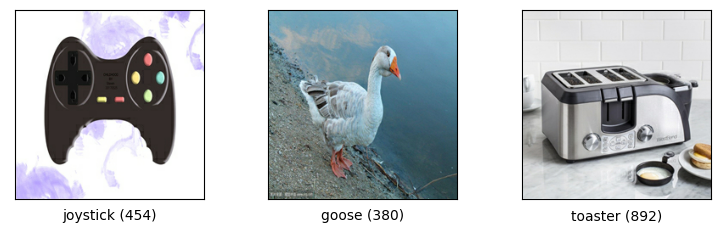

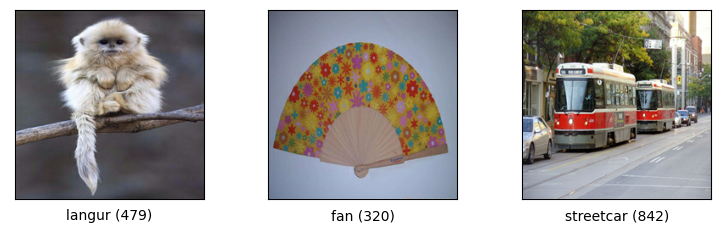

In [6]:
print("Training:   {}".format(len(train_ds_original)))
print("Validation: {}".format(len(val_ds_original)))

_ = tfds.show_examples(train_ds_original.take(3), ds_info, image_key="image")
_ = tfds.show_examples(val_ds_original.take(3), ds_info, image_key="image")

## Prepare dataset

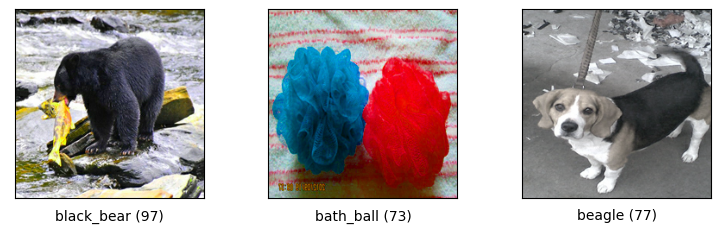

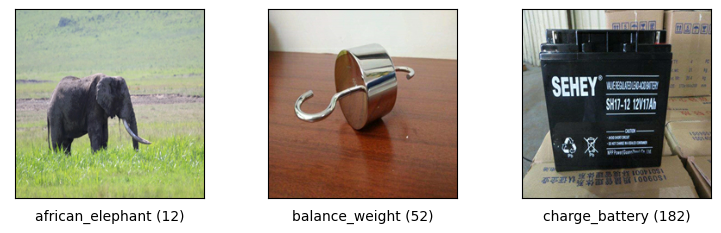

In [7]:
# Filters & augmentation
filter_labels = lambda image, label: label < num_classes


def resize_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    image = tf.image.resize_with_crop_or_pad(
        image, img_height, img_width
    )

    return image, label


def augment_images(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_saturation(image, 0.2, 3)
    image = tf.image.random_hue(image, 0.04)

    return image, label


# Prepare dataset
train_ds = (
    train_ds_original
    .filter(filter_labels)
    .map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds_original
    .filter(filter_labels)
    .map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

_ = tfds.show_examples(train_ds.take(3), ds_info, image_key="image")
_ = tfds.show_examples(val_ds.take(3), ds_info, image_key="image")

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

## Setup model

In [8]:
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation=None),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)),
])

# Summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 220, 220, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 110, 110, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                        

## Train model

In [9]:
# Prepare model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletHardLoss(margin=1.4),
)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20
101/101 [==============================] - 6s 34ms/step - loss: 0.5146 - val_loss: 1.0652
Epoch 2/20
101/101 [==============================] - 3s 28ms/step - loss: 0.3635 - val_loss: 0.7886
Epoch 3/20
101/101 [==============================] - 3s 28ms/step - loss: 0.2950 - val_loss: 0.4254
Epoch 4/20
101/101 [==============================] - 3s 29ms/step - loss: 0.2500 - val_loss: 0.3735
Epoch 5/20
101/101 [==============================] - 3s 28ms/step - loss: 0.2164 - val_loss: 0.3152
Epoch 6/20
101/101 [==============================] - 3s 29ms/step - loss: 0.1904 - val_loss: 0.3189
Epoch 7/20
101/101 [==============================] - 3s 29ms/step - loss: 0.1723 - val_loss: 0.3166
Epoch 8/20
101/101 [==============================] - 3s 29ms/step - loss: 0.1550 - val_loss: 0.2844
Epoch 9/20
101/101 [==============================] - 3s 29ms/step - loss: 0.1367 - val_loss: 0.2819
Epoch 10/20
101/101 [==============================] - 3s 28ms/step - loss: 0.1217 - val_lo

## Plot loss history

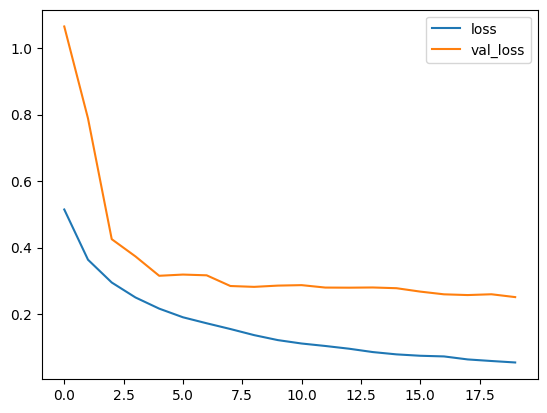

In [10]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)
_ = history_frame.loc[:, ["loss", "val_loss"]].plot()

## Generate network results 

In [11]:
# Test network
test_dataset = train_ds

results = model.predict(test_dataset)

time_suffix = datetime.now().strftime("%H:%M:%S")
np.savetxt("output/vecs-" + time_suffix + ".tsv", results, delimiter="\t")

out_m = io.open("output/meta-" + time_suffix + ".tsv", "w", encoding="utf-8")
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

101/101 [==============================] - 1s 11ms/step


## Extract embeddings

In [12]:
def get_embeddings_and_labels(ds):
    ds_embeddings = model.predict(ds)
    ds_labels = np.concatenate([y.numpy() for x, y in ds])
    assert ds_embeddings.shape[0] == ds_labels.shape[0]
    return ds_embeddings, ds_labels


train_embeddings, train_labels = get_embeddings_and_labels(train_ds)
val_embeddings, val_labels = get_embeddings_and_labels(val_ds)

26/26 [==============================] - 0s 11ms/step


## Train KNN

In [13]:
knn_finder = sk_model.GridSearchCV(
    sk_neighbors.KNeighborsClassifier(),
    param_grid={
        "n_neighbors": [1, 2, 3, 4, 5, 6, 7],
        "weights": ["uniform", "distance"],
    },
    n_jobs=-1,
)

_ = knn_finder.fit(train_embeddings, train_labels)

## Calculate accuracy

In [14]:
# Get training and validation accuracy
knn_train_score = knn_finder.best_estimator_.score(train_embeddings, train_labels)
knn_val_score = knn_finder.best_estimator_.score(val_embeddings, val_labels)

print("Training:    {:0.2f}%".format(knn_train_score * 100))
print("Validation:  {:0.2f}%".format(knn_val_score * 100))
print("Guessing:    {:0.2f}%".format(100 / num_classes))
print()
print("Improvement: {:0.2f}".format(knn_val_score / (1 / num_classes)))

Training:    100.00%
Validation:  7.98%
Guessing:    0.50%

Improvement: 15.96


## Extract embedding distances

In [15]:
def embedding_distances(ds_embeddings, ds_labels, samples):
    dist = tf.keras.metrics.MSE

    all_classes = np.unique(ds_labels)

    pos_dists = []
    for _ in tqdm(range(samples)):
        idx = np.random.choice(all_classes)
        possible_ids = np.where(ds_labels == idx)[0]
        choose_idx = np.random.choice(possible_ids, size=2)

        d = dist(ds_embeddings[choose_idx[0]], ds_embeddings[choose_idx[1]])
        pos_dists.append(d)

    neg_dists = []
    for _ in tqdm(range(samples)):
        idx = np.random.choice(all_classes)
        other_ids = np.where(ds_labels != idx)[0]
        choose_idx = np.random.choice(other_ids, size=1)

        d = dist(ds_embeddings[idx], ds_embeddings[choose_idx[0]])
        neg_dists.append(d)

    pos_dists, neg_dists = sklearn.utils.shuffle(pos_dists, neg_dists)
    return pos_dists, neg_dists


num_samples = 2 * 10e2

train_pos_dists, train_neg_dists = embedding_distances(train_embeddings, train_labels, samples=int(num_samples))
val_pos_dists, val_neg_dists = embedding_distances(val_embeddings, val_labels, samples=int(num_samples))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Thresholds

In [16]:
train_thresh = filters.threshold_otsu(np.concatenate([train_pos_dists, train_neg_dists]))
val_thresh = filters.threshold_otsu(np.concatenate([val_pos_dists, val_neg_dists]))

print("Train threshold: {:0.6f}".format(train_thresh))
print("Test threshold:  {:0.6f}".format(val_thresh))
print("Threshold diff:  {:0.4f}%".format((np.abs(train_thresh - val_thresh) / train_thresh) * 100))

Train threshold: 0.003966
Test threshold:  0.003656
Threshold diff:  7.8140%


## Evaluate model

In [17]:
train_loss = model.evaluate(train_ds)
val_loss = model.evaluate(val_ds)
print()

print("Train loss:      {:0.4f}".format(train_loss))
print("Validation loss: {:0.4f}".format(val_loss))

26/26 [==============================] - 0s 12ms/step - loss: 0.2511

Train loss:      0.0933
Validation loss: 0.2511


## Distance distribution

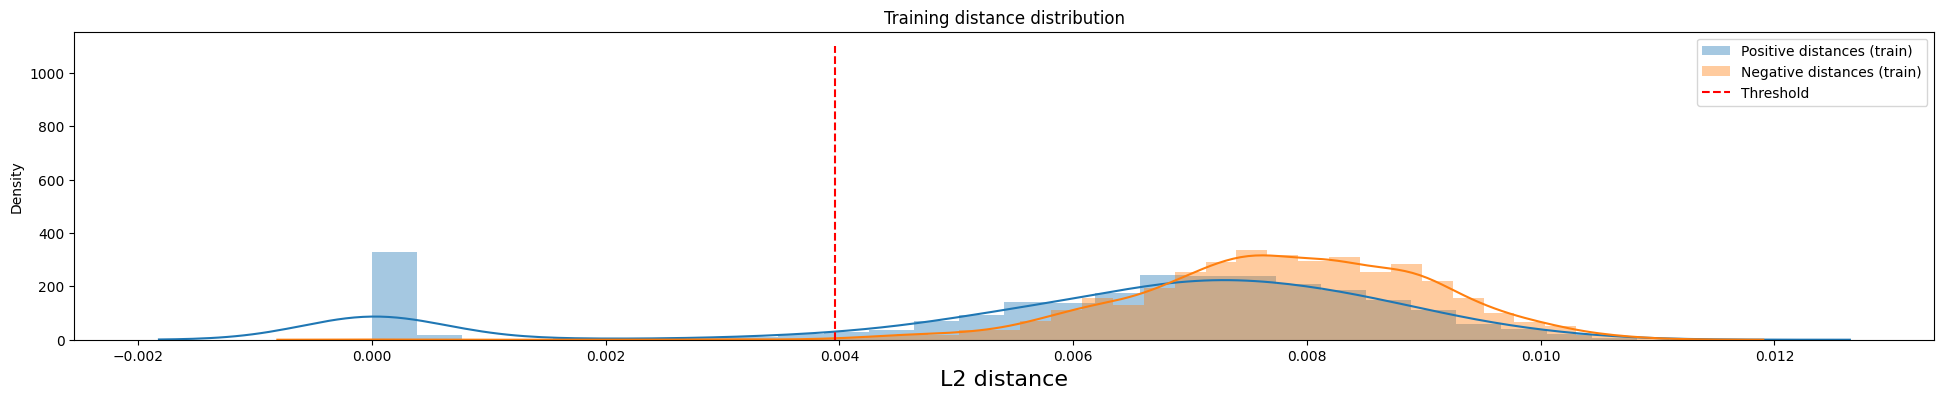

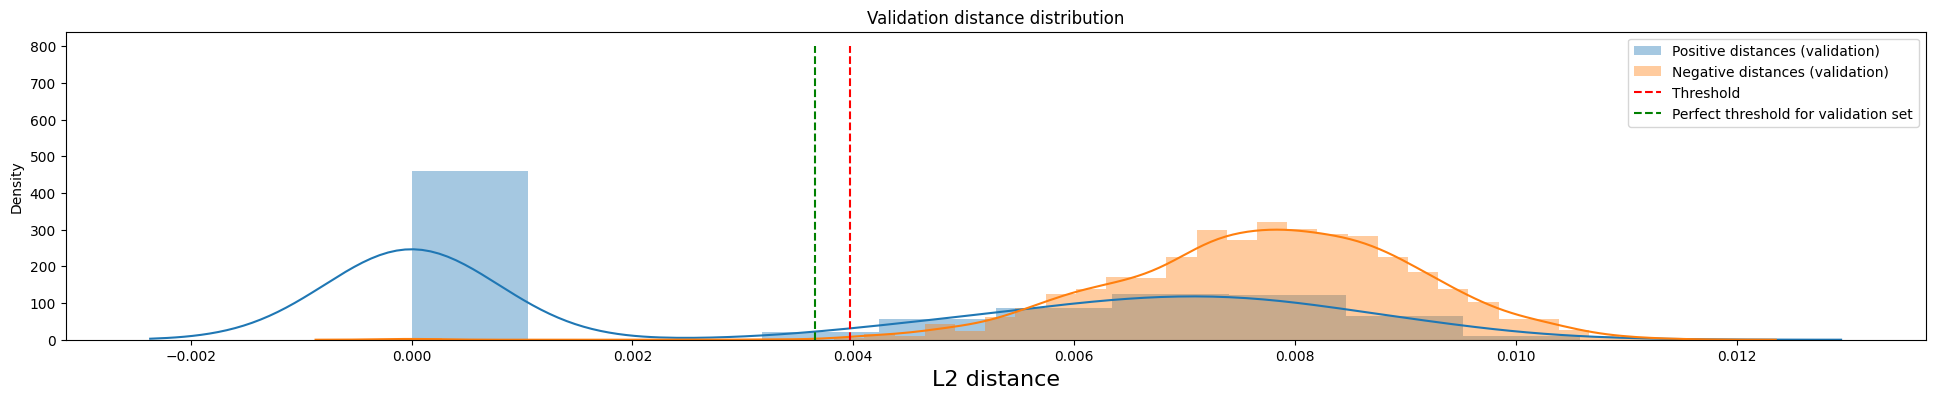

In [18]:
_, ax = plt.subplots(figsize=(24, 4))

sns.distplot(train_pos_dists, label="Positive distances (train)")
sns.distplot(train_neg_dists, label="Negative distances (train)")

ax.vlines(train_thresh, 0, 1100, color="r", linestyle="--", label="Threshold")

ax.set_title("Training distance distribution")
ax.set_xlabel("L2 distance", fontsize=16)
ax.legend()

plt.show()

_, ax = plt.subplots(figsize=(24, 4))

sns.distplot(val_pos_dists, label="Positive distances (validation)")
sns.distplot(val_neg_dists, label="Negative distances (validation)")

ax.vlines(train_thresh, 0, 800, color="r", linestyle="--", label="Threshold")
ax.vlines(val_thresh, 0, 800, color="g", linestyle="--", label="Perfect threshold for validation set")

ax.set_title("Validation distance distribution")
ax.set_xlabel("L2 distance", fontsize=16)
ax.legend()

plt.show()